In [1]:
import glob
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from matplotlib import animation
from scipy.interpolate import Rbf
import pandas as pd
import numba as nb


# Read the data and variables From Full dataset

In [2]:
path2016 = "data/jason3/2016/*.nc/*.nc"
path2017 = "data/jason3/2017/*.nc/*.nc"
path2018 = "data/jason3/2018/*.nc/*.nc"
path2019 = "data/jason3/2019/*.nc/*.nc"
path2020 = "data/jason3/2020/*.nc/*.nc"
path2021 = "data/jason3/2021/*.nc/*.nc"

#outputFile = "reduced_caspian_2018.csv"

files = glob.glob(path2020)
ncid = []

for i, file in enumerate(files):
    ncid.append(nc.Dataset(file))


In [69]:
print(ncid[3506].Conventions)

CF-1.7


In [72]:
def read_variable_data(ncid, varname):
    row = []
    try:
        for x in range(len(ncid)):
            if "CF-1.7" in ncid[x].Conventions:
                if "range_ocean" in varname or "ssha" in varname:
                    row.append(ncid[x].groups["data_01"].groups["ku"].variables[varname])
                else:
                    row.append(ncid[x].groups["data_01"].variables[varname])
            else:
                row.append(ncid[x].variables[varname])
            ## Case for 2021 data, else case for 2016 data
            #if ncid[x].variables == {}:
            #    row.append(ncid[x].groups["data_01"].variables[varname])
            #else:
    except KeyError as e:
        print("KeyError" + str(e), len(row), ncid[x].variables)
    return row

def read_pass_number(ncid, convention="1.1", varname="lat"):
    row = []
    for x in range(len(ncid)):
        try:
            if "1.1" in convention:
                ncid[x].variables[varname]
                row.append(ncid[x].pass_number)
                
            else:
                row.append(ncid[x].pass_number)

        except KeyError as e:
            print("Read pass number error: ", e, len(row), x)
            return row
    return row

## Optimized numpy attempt

In [73]:
# Read variable Data CF-1.1 Convention

latList = read_variable_data(ncid, "lat")
lonList = read_variable_data(ncid, "lon")

meanSeaSurfaceList = read_variable_data(ncid, "mean_sea_surface")
timeList = read_variable_data(ncid, "time")
surfaceTypeList = read_variable_data(ncid, "surface_type")
rangeList = read_variable_data(ncid, "range_ku")
sshaList = read_variable_data(ncid, "ssha")
altitudeList = read_variable_data(ncid, "alt")

bathymetryList = read_variable_data(ncid, "bathymetry")
geoflagsList = read_variable_data(ncid, "geophysical_quality_flag")
qualityFlagList = read_variable_data(ncid, "alt_quality_flag")
passNumberList = read_pass_number(ncid)

#dataLists = [latList, lonList, meanSeaSurfaceList, timeList, surfaceTypeList, sshaList,bathymetryList,rangeList,altitudeList, geoflagsList, qualityFlagList]
#dataListsNames = ["lat", "lon", "mss", "time", "surface type", "ssha", "elevation", "range","altitude", "geophysical quality flag", "alt quality flag", "pass number"]

dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 15000
print(height, width, len(dataLists[0]))


KeyError: 'lat'

In [66]:
print(meanSeaSurfaceList[3505])

<class 'netCDF4._netCDF4.Variable'>
int32 mean_sea_surface(time)
    _FillValue: 2147483647
    long_name: mean sea surface height above reference ellipsoid
    source: MSS_CNES_CLS-2011
    institution: CLS/CNES
    units: m
    scale_factor: 0.0001
    coordinates: lon lat
    comment: See Jason-3 User Handbook
unlimited dimensions: 
current shape = (45,)
filling on


In [9]:
# Read variable Data CF-1.7 Convention

latList = read_variable_data(ncid, "latitude")
lonList = read_variable_data(ncid, "longitude")

meanSeaSurfaceList = read_variable_data(ncid, "mean_sea_surface_cnescls")
timeList = read_variable_data(ncid, "time")
surfaceTypeList = read_variable_data(ncid, "surface_classification_flag")
rangeList = read_variable_data(ncid, "range_ocean")
sshaList = read_variable_data(ncid, "ssha")
altitudeList = read_variable_data(ncid, "altitude")

bathymetryList = read_variable_data(ncid, "depth_or_elevation")
geoflagsList = read_variable_data(ncid, "geo_qual")
#qualityFlagList = read_variable_data(ncid, "alt_qual")
passNumberList = read_pass_number(ncid, convention="1.7", varname="latitude")

dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 14500
print(height, width, len(dataLists[0]))

8 14500 4347


In [37]:
def pad(arr):
    if width - len(arr) < 0:
        print(len(arr))
    return np.pad(arr, (0, width - len(arr)), mode='constant',constant_values=(np.nan,))

vectors = []
orbitPassesMat = np.full([len(dataLists[0]), width, ], np.nan)


for i, data in enumerate(dataLists):
    print("data type: {}, {} of {}".format(dataListsNames[i], i + 1, len(dataLists)))
    tempMat = np.full([len(data), width, ], np.nan)
    for x in range(len(data)):
        # should cover reading pass number list as this is not a nested list. Otherwise read nested using x as index        
        if (i == 0):
            orbitPass = passNumberList[x]
            orbitPassesMat[x,:] = orbitPass
            
        arr = np.array(data[x])
         #   len(data[x])
        #except:
            #
        
        arr = arr.astype(np.float32)
        entries = pad(arr)
        tempMat[x,:] = entries
    
    tempVector = tempMat.flatten()
    vectors.append(tempVector)
    
    if ( i == len(dataLists) - 1):
        orbitPasses = orbitPassesMat.flatten()
        vectors.append(orbitPasses)

data type: lat, 1 of 8
data type: lon, 2 of 8
data type: time, 3 of 8
data type: mss, 4 of 8
data type: surface type, 5 of 8
data type: range, 6 of 8
data type: altitude, 7 of 8
data type: geophysical quality flag, 8 of 8


In [38]:
for x in vectors:
    print(len(x))


52590000
52590000
52590000
52590000
52590000
52590000
52590000
52590000
52590000


In [40]:
# Rotate matrix and convert to pandas dataframe
dataMat = np.array(vectors)
print(dataMat.shape)
dataMat = np.transpose(dataMat)

print(dataMat.shape)

df = pd.DataFrame(dataMat)
df.columns = dataListsNames

(9, 52590000)
(52590000, 9)


In [42]:
df = df.drop(df[(df.lon > lonMax)].index)
df = df.drop(df[(df.lon < lonMin)].index)



In [43]:
df = df.drop(df[(df.lat > latMax)].index)
df = df.drop(df[(df.lat < latMin)].index)

In [44]:
df = df.dropna()

In [45]:

df["day"] = ""
df["month"] = ""
df["year"] = ""

base_date = datetime(2000, 1, 1)
print("Day")
df["day"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).day)
print("Month")
df["month"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).month)
print("Year")
df["year"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).year)


Day
Month
Year


In [46]:
df.head(100)

,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year
180803,47.969185,47.887955,631237120.0,-10.8362,3.0,2.147484e+09,1349423.375,127.0,167.0,1,1,2020
180804,47.925907,47.932610,631237120.0,-10.8899,3.0,1.349427e+06,1349409.750,127.0,167.0,1,1,2020
180805,47.882607,47.977180,631237120.0,-10.8655,3.0,2.147484e+09,1349396.125,127.0,167.0,1,1,2020
180806,47.839287,48.021667,631237120.0,-10.8325,3.0,2.147484e+09,1349382.500,127.0,167.0,1,1,2020
180807,47.795944,48.066078,631237120.0,-10.8018,3.0,2.147484e+09,1349369.000,127.0,167.0,1,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
180898,43.786331,51.782925,631237184.0,-11.3925,3.0,2.147484e+09,1348107.125,127.0,167.0,1,1,2020
180899,43.741318,51.820770,631237184.0,-11.4528,3.0,2.147484e+09,1348093.000,127.0,167.0,1,1,2020
180900,43.696281,51.858555,631237184.0,-11.4517,3.0,2.147484e+09,1348078.875,127.0,167.0,1,1,2020
180901,43.651234,51.896275,631237184.0,-11.4650,3.0,2.147484e+09,1348064.750,127.0,167.0,1,1,2020


In [47]:
df.to_csv(r'reduced_caspian_2020.csv', index=False)


In [48]:
data = df.loc[(df.month == 12) &(df.year == 2016) & (df["surface type"] == 1)]
data.head(10000)


,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year


[]


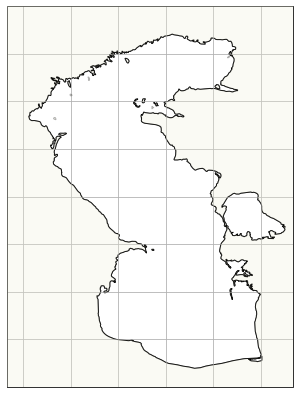

In [59]:
import cartopy.crs as crs
import cartopy.feature as feat

def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

data = df.loc[(df.month == 12) & (df["surface type"] == 1)]


fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

print(data["pass number"].unique())
